# Abstract classification with Neural Nets

In [1]:
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import  TfidfVectorizer
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix

from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam

import utils # all datareading and preprocessing functionality

## Current analysis configuration

In [2]:
file1 = './data/abstract_set1.txt'
file2 = './data/abstract_set2.txt'
data_selection = 'abstract_clean'
label_selection = 'label'

In [3]:
# the custom class Tokenizer can also lemmatize, and remove short words, digits and stopwords
stopwords = utils.get_stopwords(custom = {'wa', 'use', 'using', 'one', 'two', 'three', 'study'}) 
#custom = {'pesticide', 'pesticides'})

tokenizer = utils.Tokenizer(stop_words=stopwords, min_length=3)
#tokenizer = utils.StemTokenizer()

vectorizer = TfidfVectorizer(tokenizer=tokenizer, max_features=2500)
#vectorizer = CountVectorizer(tokenizer=tokenizer) 

**Note on max_features:** If not None, build a vocabulary that only consider the top max_features ordered by term frequency across the corpus. Otherwise, all features are used.

## Load, preprocess and inspect

In [16]:
data = utils.read_abstract_data(negatives_path=file2, positives_path=file1)

# no need to catch return value; dataframe operations are in-place
# no need to remove punctuation in this step when using nltk.tokenize_word() 
# which is implemented in utils.tokenize_text()
utils.preprocess_text(data)

data.head()

,pmid,title,abstract,label,text_label,title_clean,abstract_clean
0,29981025,Impact of Neoadjuvant Chemotherapy on Breast C...,"BACKGROUND: Breast cancer subtype, as determin...",0,control,impact of neoadjuvant chemotherapy on breast c...,"background: breast cancer subtype, as determin..."
1,29984001,Expert-Performed Endotracheal Intubation-Relat...,The aim of this study was to determine complic...,0,control,expert-performed endotracheal intubation-relat...,the aim of this study was to determine complic...
2,29988545,A case report: Addison disease caused by adren...,We report middle age man with skin hyperpigmen...,0,control,a case report: addison disease caused by adren...,we report middle age man with skin hyperpigmen...
3,29998100,An Unusual Morphological Presentation of Cutan...,Cutaneous squamous cell carcinoma (SCC) exhibi...,0,control,an unusual morphological presentation of cutan...,cutaneous squamous cell carcinoma (scc) exhibi...
4,29999256,Informing Consent: Medical Malpractice and the...,"Since the early 1990s, jurisdictions around th...",0,control,informing consent: medical malpractice and the...,"since the early 1990s, jurisdictions around th..."


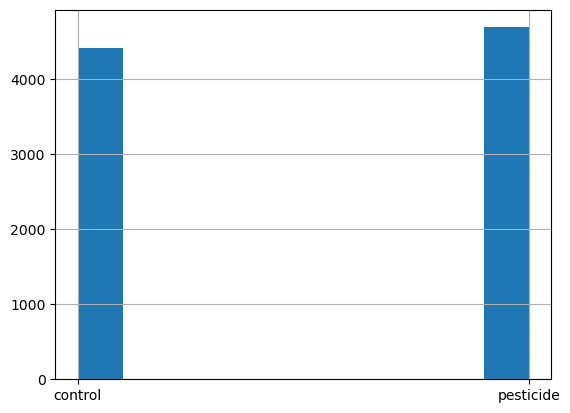

In [17]:
data['text_label'].hist();

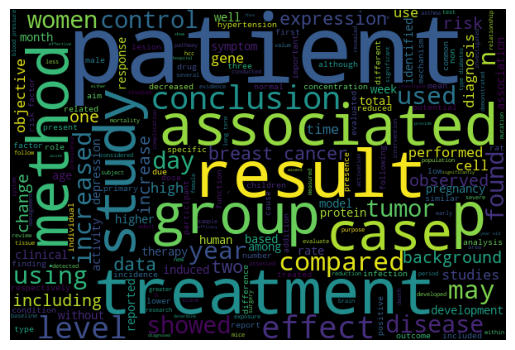

In [18]:
utils.visualize(data, 'control')

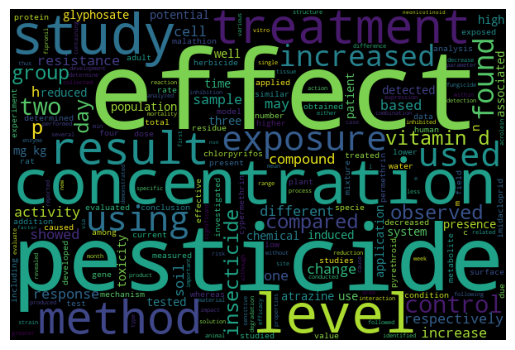

In [19]:
#run this to relad the utils module after changes during session
# from importlib import reload 
# reload(utils);
utils.visualize(data, 'pesticide')

## Create train and test data


In [20]:
x_train, x_test, y_train, y_test = train_test_split(data[data_selection], data[label_selection], random_state=123)

In [21]:
x_train_vec = vectorizer.fit_transform(x_train)
x_test_vec = vectorizer.transform(x_test)
# Note the use of different functions for train and test data !

x_train_vec.shape # is a sparse matrix!

/Users/michielnoback/opt/miniconda3/envs/nlp/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


(6832, 2500)

In [22]:
# data must not be sparse matrix before passing into tensorflow
x_train_vec = x_train_vec.toarray()
x_test_vec = x_test_vec.toarray()
x_train_vec.shape

(6832, 2500)

In [ ]:
#run this to relad the utils module after changes during session
# from importlib import reload 
# reload(utils)
#utils.plot_top_words(lda, feature_names, n_components = n_components, n_top_words=10);

<module 'utils' from '/Users/michielnoback/Library/CloudStorage/OneDrive-HanzehogeschoolGroningen/study_materials/nlp_course_notebooks/pesticide_literature/utils.py'>

In [23]:
# number of columns from input dimensions required to specify in the model
print(x_train_vec.shape)
D = x_train_vec.shape[1]

(6832, 2500)


In [24]:
# build model
i = Input(shape=(D,))

# Dense layer with D inputs and one output; no sigmoid here because included in loss
x = Dense(1)(i) 

model = Model(i, x)

In [25]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 2500)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         2,501 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,501 (9.77 KB)

 Trainable params: 2,501 (9.77 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
model.compile(
  loss=BinaryCrossentropy(from_logits=True), # different from regression
  optimizer=Adam(learning_rate=0.01), # much lower learning rate
  metrics=['accuracy']            # different from regression; will have two metrics: accuracy and loss
)

In [27]:
r = model.fit(
  x_train_vec, y_train,
  #validation data only with classification!
  validation_data=(x_test_vec, y_test),
  epochs=40,
  batch_size=128,
)

Epoch 1/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5502 - loss: 0.6139 - val_accuracy: 0.8402 - val_loss: 0.4407
Epoch 2/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8785 - loss: 0.3932 - val_accuracy: 0.8718 - val_loss: 0.3421
Epoch 3/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9011 - loss: 0.3111 - val_accuracy: 0.8828 - val_loss: 0.2946
Epoch 4/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9119 - loss: 0.2644 - val_accuracy: 0.8929 - val_loss: 0.2663
Epoch 5/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9242 - loss: 0.2296 - val_accuracy: 0.8977 - val_loss: 0.2472
Epoch 6/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9310 - loss: 0.2099 - val_accuracy: 0.9030 - val_loss: 0.2331
Epoch 7/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9365 - loss: 0.1935 - val_accuracy: 0.9039 - val_loss: 0.2228
Epoch 8/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9431 - loss: 0.1781 - val_accuracy: 0.9078 - val_loss:

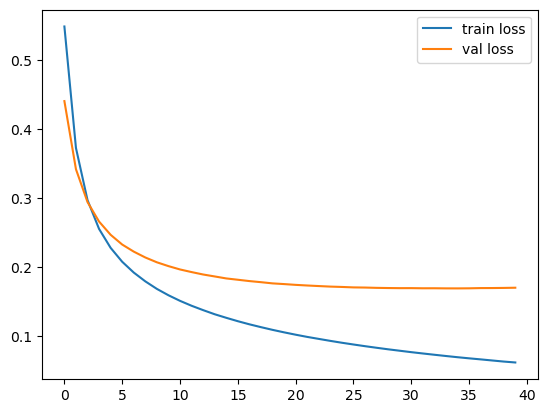

In [28]:
# Plot loss per iteration
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend();

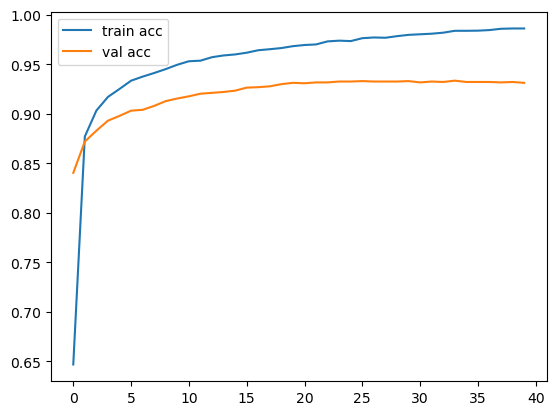

In [29]:
# Plot accuracy per iteration
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend();

In [30]:
# The outputs are not probabilities but logits;
# therefore, this check for bigger than zero (=positive class)
# mutltiply by one to get numbers instead of booleans
P_train = ((model.predict(x_train_vec) > 0) * 1.0).flatten()
P_test = ((model.predict(x_test_vec) > 0) * 1.0).flatten()

214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step


In [31]:
cm_train = confusion_matrix(y_train, P_train, normalize='true')
cm_train

array([[0.9906401 , 0.0093599 ],
       [0.01164773, 0.98835227]])

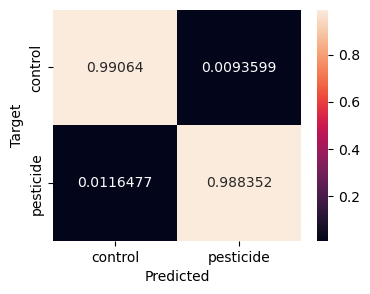

In [33]:
utils.plot_confusion_matrix(cm_train, ['control', 'pesticide'])

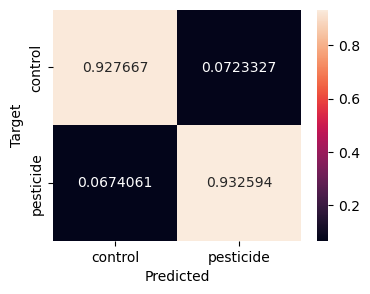

In [36]:
cm_test = confusion_matrix(y_test, P_test, normalize='true')
utils.plot_confusion_matrix(cm_test, ['control', 'pesticide'])

In [37]:
Pr_train = model.predict(x_train_vec)
Pr_test = model.predict(x_test_vec)
print("Train AUC:", roc_auc_score(y_train, Pr_train))
print("Test AUC:", roc_auc_score(y_test, Pr_test))

214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step
Train AUC: 0.9992748476613965
Test AUC: 0.9820279085842657


In [38]:
print("Train F1:", f1_score(y_train, P_train))
print("Test F1:", f1_score(y_test, P_test))

Train F1: 0.9897581792318635
Test F1: 0.9321961620469084


In [39]:
model.layers

[<InputLayer name=input_layer, built=True>, <Dense name=dense, built=True>]

In [40]:
model.layers[1].get_weights()
# word weights and bias

[array([[-0.37711066],
        [ 0.46528628],
        [-3.3756359 ],
        ...,
        [ 0.22752103],
        [ 1.8474501 ],
        [ 0.27583393]], dtype=float32),
 array([0.2991792], dtype=float32)]

In [41]:
# store the weights
weights = model.layers[1].get_weights()[0]

In [42]:
word_index_map = vectorizer.vocabulary_
#word_index_map

Gives:
```
{'treated': 1895,
 'available': 183,
 'commercial': 339,
 'form': 744,
 'resulting': 1597,
 'tissue': 1864,
 'change': 285,
 'compared': 345,
 'control': 399,
 'group': 807,
 'examination': 661,
 'utilized': 1932,
 'insect': 950,
 'fat': 710,
 ...
```

In [46]:
# let's look at the weights for each word
# try it with different threshold values!
threshold = 4

print("terms in favor of pesticide:\n")
word_weight_tuples = []
for word, index in word_index_map.items():
    weight = weights[index, 0]
    if weight > threshold:
        word_weight_tuples.append((word, weight))

word_weight_tuples = sorted(word_weight_tuples, key=lambda x: -x[1]) # sort reverse by weight
for i in range(20):
  word, weight = word_weight_tuples[i]
  print(word, weight)

terms in favor of pesticide:

cholecalciferol 9.866127
acrolein 8.741784
benzalkonium 8.10881
azobenzene 8.06008
chloride 7.796539
chloralose 7.416203
polyacrylonitrile 7.2957835
acrylonitrile 7.1944537
permethrin 6.91738
herbicide 6.537604
vitamin 6.257621
glyphosate 6.1856866
chlorpyrifos 6.114268
femoral 6.096809
chemical 5.9006205
pesticide 5.857948
fungicide 5.7798214
cypermethrin 5.7792473
malathion 5.739318
atrazine 5.6774063


In [47]:
print("Terms in favor of control:\n")
word_weight_tuples = []
for word, index in word_index_map.items():
    weight = weights[index, 0]
    if weight < -threshold:
        word_weight_tuples.append((word, weight))

word_weight_tuples = sorted(word_weight_tuples, key=lambda x: x[1]) # sort by weight
for i in range(20):
  word, weight = word_weight_tuples[i]
  print(word, weight)


Terms in favor of control:

depression -7.279711
neurodegenerative -7.0391097
hypertension -6.6067452
adenocarcinoma -6.4562078
osteosarcoma -5.7061596
fertility -5.6478
switching -5.6337113
parkinson -5.612517
hepatitis -5.577675
anemia -5.532473
fever -5.43495
fatigue -5.4148364
infarction -5.3961234
asthma -5.2714596
cyst -5.219236
breast -5.1991696
cirrhosis -5.172266
delivered -5.128744
hypertensive -5.1202536
imbalance -5.028414


### TODO: how can this information be turned into use cases?